In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
from pathlib import Path
import json
import cv2
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
import torchvision
from torchvision.models.detection import fcos_resnet50_fpn
from torchvision.models import ResNet50_Weights
import numpy as np
from collections import defaultdict
import torch

Mounted at /content/drive


In [ ]:
import os, time
from pathlib import Path

# SESUAIKAN ini dengan folder di Drive kamu
DRIVE_DATASET = "/content/drive/MyDrive/VisDroneDataset/VisDrone2019_5cls"
LOCAL_DATASET = "/content/VisDrone2019_5cls_local"

drive_dataset = Path(DRIVE_DATASET)
local_dataset = Path(LOCAL_DATASET)

if not drive_dataset.exists():
    raise FileNotFoundError(f"Folder di Drive tidak ketemu: {drive_dataset}")

start = time.time()

if not local_dataset.exists():
    print(f"📂 Copy dataset dari Drive -> {LOCAL_DATASET} (sekali saja)...")
    # -r = recursive
    !cp -r "$DRIVE_DATASET" "$LOCAL_DATASET"
    print("✅ Copy selesai.")
else:
    print("✅ Folder lokal sudah ada, SKIP copy.")

print(f"Waktu copy/cek: {time.time() - start:.1f} detik")

# Cek isi folder lokal level 1
print("\nIsi /content:")
!ls -d /content/*

print("\nIsi folder lokal VisDrone:")
!ls -R "$LOCAL_DATASET" | head -n 40


📂 Copy dataset dari Drive -> /content/VisDrone2019_5cls_local (sekali saja)...
✅ Copy selesai.
Waktu copy/cek: 1132.3 detik

Isi /content:
/content/drive	/content/sample_data  /content/VisDrone2019_5cls_local

Isi folder lokal VisDrone:
/content/VisDrone2019_5cls_local:
annotations_coco
images
labels

/content/VisDrone2019_5cls_local/annotations_coco:
instances_train.json
instances_val.json

/content/VisDrone2019_5cls_local/images:
train
train_2roda
val

/content/VisDrone2019_5cls_local/images/train:
0000002_00005_d_0000014.jpg
0000002_00448_d_0000015.jpg
0000003_00231_d_0000016.jpg
0000007_04999_d_0000036.jpg
0000007_05499_d_0000037.jpg
0000007_05999_d_0000038.jpg
0000008_00889_d_0000039.jpg
0000008_01999_d_0000040.jpg
0000008_02499_d_0000041.jpg
0000008_02999_d_0000042.jpg
0000008_03499_d_0000043.jpg
0000008_03999_d_0000044.jpg
0000008_04499_d_0000045.jpg
0000010_00569_d_0000056.jpg
0000010_05149_d_0000057.jpg
0000010_05291_d_0000058.jpg
0000013_00465_d_0000067.jpg
0000016_00420_d_00

In [ ]:
from pathlib import Path

BASE_LOCAL = Path("/content")

# Kalau hasil copy tadi langsung "images/train" di dalamnya:
cand1 = BASE_LOCAL / "VisDrone2019_5cls_local"
cand2 = BASE_LOCAL / "VisDrone2019_5cls_local" / "VisDrone2019_5cls"  # kalau double folder

print("Cek kandidat 1:", cand1)
print("  subdir:", [p.name for p in cand1.iterdir()])

valid_root = None

# kandidat 1 valid kalau ada images/train
if (cand1 / "images" / "train").is_dir():
    valid_root = cand1
# kandidat 2 valid kalau ada images/train
elif (cand2 / "images" / "train").is_dir():
    valid_root = cand2

if valid_root is None:
    raise RuntimeError(
        "Tidak menemukan folder dengan struktur images/train di bawah "
        "VisDrone2019_5cls_local. Cek output ls di cell sebelumnya dan sesuaikan path."
    )

YOLO_ROOT = valid_root
IMG_TRAIN = YOLO_ROOT / "images" / "train"
LBL_TRAIN = YOLO_ROOT / "labels" / "train"
IMG_VAL   = YOLO_ROOT / "images" / "val"
LBL_VAL   = YOLO_ROOT / "labels" / "val"

print("\n✅ YOLO_ROOT:", YOLO_ROOT)
print("Train img dir:", IMG_TRAIN)
print("Train lbl dir:", LBL_TRAIN)
print("Val   img dir:", IMG_VAL)
print("Val   lbl dir:", LBL_VAL)

assert IMG_TRAIN.is_dir(), "IMG_TRAIN tidak ada, path salah."
assert LBL_TRAIN.is_dir(), "LBL_TRAIN tidak ada, path salah."
assert IMG_VAL.is_dir(),   "IMG_VAL tidak ada, path salah."
assert LBL_VAL.is_dir(),   "LBL_VAL tidak ada, path salah."


Cek kandidat 1: /content/VisDrone2019_5cls_local
  subdir: ['annotations_coco', 'labels', 'images']

✅ YOLO_ROOT: /content/VisDrone2019_5cls_local
Train img dir: /content/VisDrone2019_5cls_local/images/train
Train lbl dir: /content/VisDrone2019_5cls_local/labels/train
Val   img dir: /content/VisDrone2019_5cls_local/images/val
Val   lbl dir: /content/VisDrone2019_5cls_local/labels/val


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image

CLASSES = ["bicycle", "car", "truck", "bus", "motorcycle"]

class YoloDetectionDataset(Dataset):
    def __init__(self, img_dir, lbl_dir, transforms=None, use_cache=True):
        self.img_dir = Path(img_dir)
        self.lbl_dir = Path(lbl_dir)
        self.transforms = transforms
        self.use_cache = use_cache

        self.img_files = sorted([
            p for p in self.img_dir.iterdir()
            if p.suffix.lower() in [".jpg", ".jpeg", ".png"]
        ])

        print(f"Found {len(self.img_files)} images in {self.img_dir}")

        self.cache = {} if use_cache else None

    def __len__(self):
        return len(self.img_files)

    def _load_image(self, img_path):
        key = str(img_path)

        if self.use_cache and key in self.cache:
            return self.cache[key].copy()

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"[WARNING] Corrupt image skipped: {img_path} — {e}")
            new_idx = torch.randint(0, len(self.img_files), (1,)).item()
            return self._load_image(self.img_files[new_idx])

        if self.use_cache:
            self.cache[key] = img.copy()

        return img

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        img = self._load_image(img_path)
        w, h = img.size

        label_path = self.lbl_dir / f"{img_path.stem}.txt"
        boxes = []
        labels = []

        if label_path.exists():
            with open(label_path) as f:
                for ln in f:
                    parts = ln.strip().split()
                    if len(parts) != 5:
                        continue

                    cls_id = int(parts[0])
                    x_c, y_c, bw, bh = map(float, parts[1:])

                    x_c *= w
                    y_c *= h
                    bw  *= w
                    bh  *= h

                    x1 = x_c - bw / 2
                    y1 = y_c - bw / 2  # (opsional: boleh tetap y_c - bh/2 kalau tadi sudah benar)
                    y1 = y_c - bh / 2
                    x2 = x_c + bw / 2
                    y2 = y_c + bh / 2

                    x1 = max(0, min(x1, w - 1))
                    y1 = max(0, min(y1, h - 1))
                    x2 = max(0, min(x2, w - 1))
                    y2 = max(0, min(y2, h - 1))

                    if x2 <= x1 or y2 <= y1:
                        continue

                    boxes.append([x1, y1, x2, y2])
                    labels.append(cls_id + 1)

        boxes  = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target


def collate_fn(batch):
    images, targets = list(zip(*batch))
    return list(images), list(targets)


In [ ]:
train_tfms = T.ToTensor()
val_tfms   = T.ToTensor()

train_dataset = YoloDetectionDataset(
    IMG_TRAIN,
    LBL_TRAIN,
    transforms=train_tfms,
    use_cache=False,
)

val_dataset = YoloDetectionDataset(
    IMG_VAL,
    LBL_VAL,
    transforms=val_tfms,
    use_cache=False,
)

batch_size = 12  # kalau OOM → 2

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,          # lokal, boleh 2
    pin_memory=True,
    collate_fn=collate_fn,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    collate_fn=collate_fn,
)

print("Train images:", len(train_dataset))
print("Val images  :", len(val_dataset))


Found 6318 images in /content/VisDrone2019_5cls_local/images/train
Found 546 images in /content/VisDrone2019_5cls_local/images/val
Train images: 6318
Val images  : 546


In [ ]:
import torchvision
from torchvision.models.detection import fcos_resnet50_fpn
from torchvision.models import ResNet50_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

num_classes = len(CLASSES) + 1  # +1 background

model = fcos_resnet50_fpn(
    weights=None,
    weights_backbone=ResNet50_Weights.IMAGENET1K_V1,
    num_classes=num_classes,
    min_size=640,
    max_size=640,
)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=1e-3,
    momentum=0.9,
    weight_decay=1e-4,
)


NameError: name 'torch' is not defined

In [ ]:
!pip install -q tqdm
from tqdm import tqdm
import time

num_epochs = 30   # FCOS baseline

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    print(f"\n===== Epoch {epoch+1}/{num_epochs} =====")
    pbar = tqdm(train_loader, desc="Training", unit="batch")
    start_time = time.time()

    for images, targets in pbar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = epoch_loss / max(1, len(train_loader))
    elapsed = time.time() - start_time

    print(f"Epoch {epoch+1} avg loss: {avg_loss:.4f}")
    print(f"Time per epoch: {elapsed:.1f} sec (~{elapsed/60:.2f} min)")


===== Epoch 1/30 =====


Training:  20%|██        | 108/527 [01:09<04:29,  1.55batch/s, loss=1.9555]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:40<00:00,  1.55batch/s, loss=1.9248]


Epoch 1 avg loss: 1.9632
Time per epoch: 340.1 sec (~5.67 min)

===== Epoch 2/30 =====


Training:  66%|██████▌   | 347/527 [03:44<01:56,  1.54batch/s, loss=1.8671]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:41<00:00,  1.54batch/s, loss=1.8182]


Epoch 2 avg loss: 1.8778
Time per epoch: 341.1 sec (~5.69 min)

===== Epoch 3/30 =====


Training:  11%|█         | 57/527 [00:36<05:07,  1.53batch/s, loss=1.8553]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:41<00:00,  1.54batch/s, loss=1.9064]


Epoch 3 avg loss: 1.8544
Time per epoch: 341.2 sec (~5.69 min)

===== Epoch 4/30 =====


Training:  18%|█▊        | 93/527 [01:00<04:35,  1.58batch/s, loss=1.8656]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:41<00:00,  1.54batch/s, loss=1.8474]


Epoch 4 avg loss: 1.8395
Time per epoch: 341.2 sec (~5.69 min)

===== Epoch 5/30 =====


Training:  93%|█████████▎| 492/527 [05:19<00:22,  1.55batch/s, loss=1.8165]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:41<00:00,  1.54batch/s, loss=1.8976]


Epoch 5 avg loss: 1.8283
Time per epoch: 341.5 sec (~5.69 min)

===== Epoch 6/30 =====


Training:  24%|██▍       | 126/527 [01:21<04:24,  1.51batch/s, loss=1.3161]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:40<00:00,  1.55batch/s, loss=1.1990]


Epoch 6 avg loss: 1.3808
Time per epoch: 341.0 sec (~5.68 min)

===== Epoch 7/30 =====


Training:  34%|███▍      | 181/527 [01:56<03:41,  1.56batch/s, loss=1.1791]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:40<00:00,  1.55batch/s, loss=1.1756]


Epoch 7 avg loss: 1.2133
Time per epoch: 340.9 sec (~5.68 min)

===== Epoch 8/30 =====


Training:  90%|█████████ | 475/527 [05:07<00:33,  1.56batch/s, loss=1.1976]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:40<00:00,  1.55batch/s, loss=1.1056]


Epoch 8 avg loss: 1.1824
Time per epoch: 340.8 sec (~5.68 min)

===== Epoch 9/30 =====


Training:  94%|█████████▎| 493/527 [05:19<00:22,  1.52batch/s, loss=1.2124]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:41<00:00,  1.54batch/s, loss=1.2329]


Epoch 9 avg loss: 1.1622
Time per epoch: 341.2 sec (~5.69 min)

===== Epoch 10/30 =====


Training:  71%|███████   | 372/527 [04:00<01:39,  1.56batch/s, loss=1.1889]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:40<00:00,  1.55batch/s, loss=1.1991]


Epoch 10 avg loss: 1.1451
Time per epoch: 340.9 sec (~5.68 min)

===== Epoch 11/30 =====


Training:  92%|█████████▏| 486/527 [05:15<00:26,  1.55batch/s, loss=1.1305]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:41<00:00,  1.54batch/s, loss=1.0667]


Epoch 11 avg loss: 1.1287
Time per epoch: 341.5 sec (~5.69 min)

===== Epoch 12/30 =====


Training:  16%|█▌        | 82/527 [00:52<04:42,  1.57batch/s, loss=1.0308]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:41<00:00,  1.54batch/s, loss=1.1029]


Epoch 12 avg loss: 1.1167
Time per epoch: 341.2 sec (~5.69 min)

===== Epoch 13/30 =====


Training:   4%|▎         | 19/527 [00:12<05:29,  1.54batch/s, loss=1.0942]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:40<00:00,  1.55batch/s, loss=1.1728]


Epoch 13 avg loss: 1.1051
Time per epoch: 341.0 sec (~5.68 min)

===== Epoch 14/30 =====


Training:  32%|███▏      | 168/527 [01:48<03:58,  1.50batch/s, loss=1.0974]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:41<00:00,  1.54batch/s, loss=1.1208]


Epoch 14 avg loss: 1.0943
Time per epoch: 341.3 sec (~5.69 min)

===== Epoch 15/30 =====


Training:  75%|███████▌  | 396/527 [04:16<01:26,  1.51batch/s, loss=1.0726]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:41<00:00,  1.55batch/s, loss=1.1106]


Epoch 15 avg loss: 1.0841
Time per epoch: 341.0 sec (~5.68 min)

===== Epoch 16/30 =====


Training:  37%|███▋      | 196/527 [02:07<03:34,  1.54batch/s, loss=1.0646]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:40<00:00,  1.55batch/s, loss=1.1056]


Epoch 16 avg loss: 1.0749
Time per epoch: 340.9 sec (~5.68 min)

===== Epoch 17/30 =====


Training:  66%|██████▌   | 349/527 [03:46<01:52,  1.59batch/s, loss=1.0440]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:40<00:00,  1.55batch/s, loss=1.0591]


Epoch 17 avg loss: 1.0660
Time per epoch: 340.9 sec (~5.68 min)

===== Epoch 18/30 =====


Training:  55%|█████▌    | 292/527 [03:08<02:34,  1.52batch/s, loss=1.0464]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:41<00:00,  1.54batch/s, loss=1.1061]


Epoch 18 avg loss: 1.0577
Time per epoch: 341.2 sec (~5.69 min)

===== Epoch 19/30 =====


Training:  33%|███▎      | 175/527 [01:53<03:39,  1.60batch/s, loss=0.9591]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:41<00:00,  1.54batch/s, loss=0.9944]


Epoch 19 avg loss: 1.0482
Time per epoch: 341.2 sec (~5.69 min)

===== Epoch 20/30 =====


Training:  86%|████████▌ | 454/527 [04:53<00:47,  1.54batch/s, loss=1.0420]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:41<00:00,  1.55batch/s, loss=1.0482]


Epoch 20 avg loss: 1.0405
Time per epoch: 341.1 sec (~5.68 min)

===== Epoch 21/30 =====


Training:  41%|████      | 214/527 [02:18<03:20,  1.56batch/s, loss=1.0028]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:41<00:00,  1.55batch/s, loss=1.0419]


Epoch 21 avg loss: 1.0334
Time per epoch: 341.0 sec (~5.68 min)

===== Epoch 22/30 =====


Training:   3%|▎         | 15/527 [00:09<05:29,  1.56batch/s, loss=0.9567]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:40<00:00,  1.55batch/s, loss=1.1028]


Epoch 22 avg loss: 1.0245
Time per epoch: 340.9 sec (~5.68 min)

===== Epoch 23/30 =====


Training:  73%|███████▎  | 384/527 [04:09<01:34,  1.52batch/s, loss=1.0413]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:41<00:00,  1.54batch/s, loss=1.0157]


Epoch 23 avg loss: 1.0180
Time per epoch: 341.9 sec (~5.70 min)

===== Epoch 24/30 =====


Training:  71%|███████   | 372/527 [04:01<01:41,  1.53batch/s, loss=0.9461]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:41<00:00,  1.54batch/s, loss=0.9538]


Epoch 24 avg loss: 1.0102
Time per epoch: 341.4 sec (~5.69 min)

===== Epoch 25/30 =====


Training:   7%|▋         | 36/527 [00:23<05:23,  1.52batch/s, loss=1.0308]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:40<00:00,  1.55batch/s, loss=1.0405]


Epoch 25 avg loss: 1.0023
Time per epoch: 341.0 sec (~5.68 min)

===== Epoch 26/30 =====


Training:  10%|█         | 55/527 [00:35<05:07,  1.53batch/s, loss=1.0397]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:40<00:00,  1.55batch/s, loss=1.0309]


Epoch 26 avg loss: 0.9950
Time per epoch: 340.3 sec (~5.67 min)

===== Epoch 27/30 =====


Training:  65%|██████▌   | 345/527 [03:43<02:02,  1.49batch/s, loss=0.9231]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:40<00:00,  1.55batch/s, loss=0.9424]


Epoch 27 avg loss: 0.9869
Time per epoch: 341.0 sec (~5.68 min)

===== Epoch 28/30 =====


Training:  84%|████████▍ | 445/527 [04:48<00:53,  1.53batch/s, loss=0.9512]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:41<00:00,  1.54batch/s, loss=0.9932]


Epoch 28 avg loss: 0.9818
Time per epoch: 341.3 sec (~5.69 min)

===== Epoch 29/30 =====


Training:  81%|████████  | 428/527 [04:37<01:03,  1.56batch/s, loss=0.9559]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:41<00:00,  1.54batch/s, loss=0.9698]


Epoch 29 avg loss: 0.9731
Time per epoch: 341.1 sec (~5.69 min)

===== Epoch 30/30 =====


Training:  46%|████▌     | 243/527 [02:37<03:03,  1.55batch/s, loss=0.9215]

[WARNING] Corrupt image skipped: /content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg — cannot identify image file '/content/VisDrone2019_5cls_local/images/train/0000070_05880_d_0000005.jpg'


Training: 100%|██████████| 527/527 [05:40<00:00,  1.55batch/s, loss=0.9553]

Epoch 30 avg loss: 0.9677
Time per epoch: 340.9 sec (~5.68 min)


In [ ]:
save_path = "/content/drive/MyDrive/VisDroneDataset/fcos_visdrone_5cls/fcos_resnet50_fpn_visdrone_5cls.pth"
torch.save(model.state_dict(), save_path)
print("Saved FCOS model to:", save_path)


Saved FCOS model to: /content/drive/MyDrive/VisDroneDataset/fcos_visdrone_5cls/fcos_resnet50_fpn_visdrone_5cls.pth


In [ ]:
import numpy as np
from collections import defaultdict
import torch

def box_iou(box1, box2):
    """
    box1: [N, 4], box2: [M, 4] dalam format (xmin, ymin, xmax, ymax)
    return matriks IoU [N, M]
    """
    box1 = np.asarray(box1)
    box2 = np.asarray(box2)

    N = box1.shape[0]
    M = box2.shape[0]
    if N == 0 or M == 0:
        return np.zeros((N, M), dtype=np.float32)

    # Intersection
    lt = np.maximum(box1[:, None, :2], box2[None, :, :2])  # [N,M,2]
    rb = np.minimum(box1[:, None, 2:], box2[None, :, 2:])  # [N,M,2]
    wh = np.clip(rb - lt, a_min=0, a_max=None)
    inter = wh[..., 0] * wh[..., 1]  # [N,M]

    # Area
    area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])

    union = area1[:, None] + area2[None, :] - inter
    union = np.clip(union, a_min=1e-6, a_max=None)
    iou = inter / union
    return iou

def compute_ap(recall, precision):
    """
    Hitung AP ala COCO (integral kurva P-R).
    recall, precision: array 1D (sudah cumulative).
    """
    recall = np.asarray(recall)
    precision = np.asarray(precision)
    # Tambah sentinel
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))
    # precision monotonically decreasing
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])
    # titik saat recall berubah
    idx = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[idx + 1] - mrec[idx]) * mpre[idx + 1])
    return ap

@torch.no_grad()
def evaluate_fcos_yolo_style(model, data_loader, device, class_names,
                             conf_thres=0.001,
                             iou_thresholds=None):
    """
    Evaluasi FCOS dan print mirip format YOLO:

    Class         Images  Instances        P         R     mAP50  mAP50-95
    """
    model.eval()
    if iou_thresholds is None:
        iou_thresholds = np.arange(0.50, 0.96, 0.05)  # 0.50 .. 0.95 (10 titik)

    # Simpan GT & deteksi
    gts = {}  # (image_id, cls) -> {"boxes": [G,4], "matched": [T,G] bool}
    dets = {c: {"image_ids": [], "scores": [], "boxes": []}
            for c in range(1, len(class_names) + 1)}

    num_gts_per_class = defaultdict(int)
    images_with_class = {c: set() for c in range(1, len(class_names) + 1)}

    # Statistik speed
    n_images = 0
    t_pre = t_inf = t_post = 0.0

    import time
    from tqdm import tqdm

    for images, targets in tqdm(data_loader, desc="Evaluating", unit="batch"):
        batch_size = len(images)
        n_images += batch_size

        # --- PREPROCESS (to device) ---
        t0 = time.perf_counter()
        images = [img.to(device) for img in images]
        t1 = time.perf_counter()

        # --- INFERENCE ---
        outputs = model(images)
        if device.type == "cuda":
            torch.cuda.synchronize()
        t2 = time.perf_counter()

        # --- POSTPROCESS: kumpulkan GT & pred ---
        for i in range(batch_size):
            img_id = int(targets[i]["image_id"].item())

            # GT
            gt_boxes = targets[i]["boxes"].cpu().numpy()
            gt_labels = targets[i]["labels"].cpu().numpy()

            for cls in range(1, len(class_names) + 1):
                mask = (gt_labels == cls)
                cls_boxes = gt_boxes[mask]
                if cls_boxes.size == 0:
                    continue

                key = (img_id, cls)
                if key not in gts:
                    gts[key] = {
                        "boxes": cls_boxes.copy(),
                        "matched": np.zeros(
                            (len(iou_thresholds), cls_boxes.shape[0]),
                            dtype=bool
                        ),
                    }
                else:
                    old_boxes = gts[key]["boxes"]
                    new_boxes = np.concatenate([old_boxes, cls_boxes], axis=0)
                    gts[key]["boxes"] = new_boxes

                    old_matched = gts[key]["matched"]
                    new_matched = np.zeros(
                        (len(iou_thresholds), new_boxes.shape[0]),
                        dtype=bool
                    )
                    new_matched[:, :old_matched.shape[1]] = old_matched
                    gts[key]["matched"] = new_matched

                num_gts_per_class[cls] += cls_boxes.shape[0]
                images_with_class[cls].add(img_id)

            # Prediksi
            pred = outputs[i]
            pred_boxes = pred["boxes"].detach().cpu().numpy()
            pred_scores = pred["scores"].detach().cpu().numpy()
            pred_labels = pred["labels"].detach().cpu().numpy()

            keep = pred_scores >= conf_thres
            pred_boxes = pred_boxes[keep]
            pred_scores = pred_scores[keep]
            pred_labels = pred_labels[keep]

            for box, score, cls in zip(pred_boxes, pred_scores, pred_labels):
                cls = int(cls)
                if cls < 1 or cls > len(class_names):
                    continue
                dets[cls]["image_ids"].append(img_id)
                dets[cls]["scores"].append(float(score))
                dets[cls]["boxes"].append(box.astype(np.float32))

        t3 = time.perf_counter()
        t_pre += (t1 - t0)
        t_inf += (t2 - t1)
        t_post += (t3 - t2)

    # List -> numpy
    for cls in dets.keys():
        dets[cls]["image_ids"] = np.array(dets[cls]["image_ids"])
        dets[cls]["scores"] = np.array(dets[cls]["scores"], dtype=np.float32)
        if len(dets[cls]["boxes"]) > 0:
            dets[cls]["boxes"] = np.stack(dets[cls]["boxes"], axis=0)
        else:
            dets[cls]["boxes"] = np.zeros((0, 4), dtype=np.float32)

    T = len(iou_thresholds)
    metrics = {}  # cls -> dict

    for cls in range(1, len(class_names) + 1):
        npos = num_gts_per_class[cls]
        nimg = len(images_with_class[cls])
        scores = dets[cls]["scores"]
        boxes = dets[cls]["boxes"]
        image_ids = dets[cls]["image_ids"]

        if npos == 0:
            metrics[cls] = {
                "P": 0.0,
                "R": 0.0,
                "AP50": 0.0,
                "AP50_95": 0.0,
                "npos": 0,
                "nimg": 0,
            }
            continue

        if scores.shape[0] == 0:
            metrics[cls] = {
                "P": 0.0,
                "R": 0.0,
                "AP50": 0.0,
                "AP50_95": 0.0,
                "npos": npos,
                "nimg": nimg,
            }
            continue

        order = np.argsort(-scores)
        scores = scores[order]
        boxes = boxes[order]
        image_ids = image_ids[order]

        TPs = np.zeros((T, scores.shape[0]), dtype=np.float32)
        FPs = np.zeros((T, scores.shape[0]), dtype=np.float32)

        # matching per IoU threshold
        for t_idx, thr in enumerate(iou_thresholds):
            # reset matched per threshold
            for key in gts.keys():
                gts[key]["matched"][t_idx, :] = False

            for d_idx in range(scores.shape[0]):
                img_id = int(image_ids[d_idx])
                box = boxes[d_idx]

                key = (img_id, cls)
                if key not in gts:
                    FPs[t_idx, d_idx] = 1
                    continue

                gt_boxes = gts[key]["boxes"]
                matched = gts[key]["matched"][t_idx]

                ious = box_iou(box[None, :], gt_boxes)[0]
                best_gt = np.argmax(ious)
                best_iou = ious[best_gt]

                if best_iou >= thr and not matched[best_gt]:
                    TPs[t_idx, d_idx] = 1
                    matched[best_gt] = True
                else:
                    FPs[t_idx, d_idx] = 1

        APs = []
        P_at_50 = 0.0
        R_at_50 = 0.0

        for t_idx, thr in enumerate(iou_thresholds):
            tp = np.cumsum(TPs[t_idx])
            fp = np.cumsum(FPs[t_idx])

            recall = tp / max(npos, 1)
            precision = tp / np.maximum(tp + fp, 1e-9)

            ap = compute_ap(recall, precision)
            APs.append(ap)

            if abs(thr - 0.50) < 1e-6 and recall.size > 0:
                R_at_50 = recall[-1]
                P_at_50 = precision[-1]

        APs = np.array(APs)
        AP50 = APs[0]          # IoU 0.50
        AP50_95 = APs.mean()   # rata-rata 0.50–0.95

        metrics[cls] = {
            "P": P_at_50,
            "R": R_at_50,
            "AP50": AP50,
            "AP50_95": AP50_95,
            "npos": npos,
            "nimg": nimg,
        }

    # row "all"
    valid_classes = [c for c in metrics.keys() if metrics[c]["npos"] > 0]
    if len(valid_classes) > 0:
        P_all = np.mean([metrics[c]["P"] for c in valid_classes])
        R_all = np.mean([metrics[c]["R"] for c in valid_classes])
        mAP50_all = np.mean([metrics[c]["AP50"] for c in valid_classes])
        mAP50_95_all = np.mean([metrics[c]["AP50_95"] for c in valid_classes])
        total_instances = sum(metrics[c]["npos"] for c in valid_classes)
    else:
        P_all = R_all = mAP50_all = mAP50_95_all = 0.0
        total_instances = 0

    total_images = len(data_loader.dataset)

    # Print tabel mirip YOLO
    print("\nFCOS evaluation (YOLO-style)")
    print(f"{'Class':15s} {'Images':>7s} {'Instances':>10s} {'P':>9s} {'R':>9s} {'mAP50':>9s} {'mAP50-95':>9s}")
    print("-" * 70)
    print(f"{'all':15s} {total_images:7d} {total_instances:10d} "
          f"{P_all:9.3f} {R_all:9.3f} {mAP50_all:9.3f} {mAP50_95_all:9.3f}")

    for cls in range(1, len(class_names) + 1):
        m = metrics[cls]
        name = class_names[cls - 1]
        print(f"{name:15s} {m['nimg']:7d} {m['npos']:10d} "
              f"{m['P']:9.3f} {m['R']:9.3f} {m['AP50']:9.3f} {m['AP50_95']:9.3f}")

    # Speed
    if n_images > 0:
        ms = 1000.0
        print(f"\nSpeed: {t_pre * ms / n_images:.1f}ms preprocess, "
              f"{t_inf * ms / n_images:.1f}ms inference, "
              f"{t_post * ms / n_images:.1f}ms postprocess per image")
    else:
        print("\nSpeed: (no images?)")

    return metrics


In [ ]:
# Kalau mau load weight best terlebih dulu:
ckpt_path = "/content/drive/MyDrive/VisDroneDataset/fcos_visdrone_5cls/fcos_resnet50_fpn_visdrone_5cls.pth"
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.to(device)

# CLASSES sudah ada di notebook kamu:
# CLASSES = ["car", "motorcycle", "bus", "bicycle", "truck"]

metrics = evaluate_fcos_yolo_style(
    model,
    val_loader,
    device,
    class_names=CLASSES,
    conf_thres=0.001  # bisa kamu naikkan misal 0.01 / 0.05 kalau kebanyakan deteksi low-score
)


Evaluating: 100%|██████████| 46/46 [00:14<00:00,  3.09batch/s]



FCOS evaluation (YOLO-style)
Class            Images  Instances         P         R     mAP50  mAP50-95
----------------------------------------------------------------------
all                 546      23213     0.149     0.389     0.238     0.121
bicycle             364       1287     0.043     0.162     0.029     0.008
car                 517      16039     0.348     0.675     0.592     0.326
truck               266        750     0.068     0.387     0.165     0.081
bus                 131        251     0.107     0.430     0.262     0.144
motorcycle          485       4886     0.178     0.290     0.142     0.045

Speed: 1.0ms preprocess, 15.8ms inference, 0.3ms postprocess per image


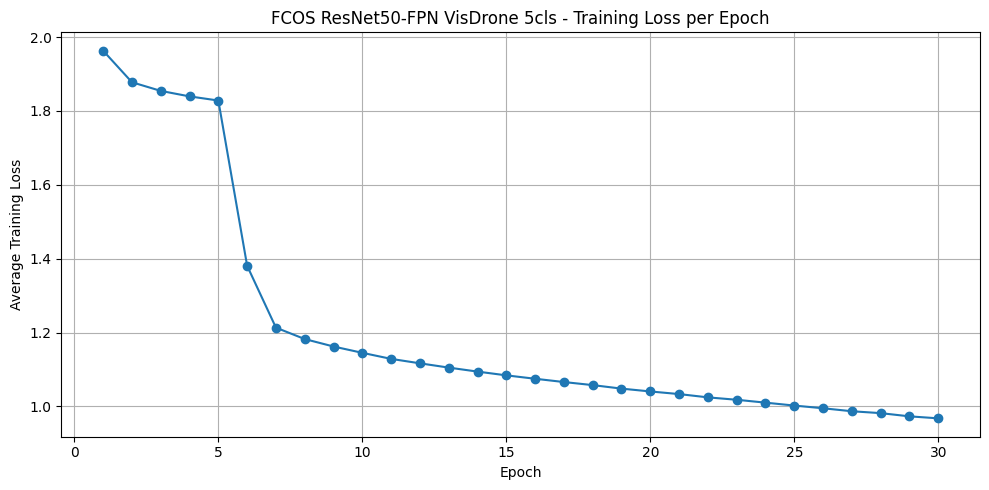

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 31))
avg_loss = [
    1.9632, 1.8778, 1.8544, 1.8395, 1.8283,
    1.3808, 1.2133, 1.1824, 1.1622, 1.1451,
    1.1287, 1.1167, 1.1051, 1.0943, 1.0841,
    1.0749, 1.0660, 1.0577, 1.0482, 1.0405,
    1.0334, 1.0245, 1.0180, 1.0102, 1.0023,
    0.9950, 0.9869, 0.9818, 0.9731, 0.9677,
]

plt.figure(figsize=(10, 5))
plt.plot(epochs, avg_loss, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Average Training Loss")
plt.title("FCOS ResNet50-FPN VisDrone 5cls - Training Loss per Epoch")
plt.grid(True)
plt.tight_layout()
plt.show()

# Simpan kalau mau
plt.savefig("fcos_training_loss_visdrone_5cls.png")
